In [1]:
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dnc.dnc import DNC
from feedforward_controller import FeedforwardController

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 15)

In [2]:
def generate_data(batch_size, length, size):

    input_data = np.zeros((batch_size, 2 * length + 1, size), dtype=np.float32)
    target_output = np.zeros((batch_size, 2 * length + 1, size), dtype=np.float32)

    sequence = np.random.binomial(1, 0.5, (batch_size, length, size - 1))

    input_data[:, :length, :size - 1] = sequence
    input_data[:, length, -1] = 1  # the end symbol
    target_output[:, length + 1:, :size - 1] = sequence
    
    return input_data, target_output

In [3]:
def binary_cross_entropy(predictions, targets):

    return tf.reduce_mean(
        -1 * targets * tf.log(predictions) - (1 - targets) * tf.log(1 - predictions)
    )

In [4]:
def visualize_op(input_series, dnc_output, memory_view):
    
    gs = gridspec.GridSpec(48, 1, hspace=0)

    ww_strip = np.squeeze(memory_view['write_weightings'])
    rw_strip = np.squeeze(memory_view['read_weightings'])
    colored_write = np.zeros((ww_strip.shape[0], ww_strip.shape[1], 3))
    colored_read = np.zeros((rw_strip.shape[0], rw_strip.shape[1], 3))
    for i in range(ww_strip.shape[0]):
        for j in range(ww_strip.shape[1]):
            colored_read[i, j] = [rw_strip[i,j], 0., 0.]
            colored_write[i, j] = [0., ww_strip[i,j], 0.]
        
    free_strip = np.vstack([np.squeeze(memory_view['free_gates'])] * 5)
    allocation_strip = np.vstack([np.squeeze(memory_view['allocation_gates'])] * 5)


    iax = plt.subplot(gs[0:5, 0])
    oax = plt.subplot(gs[7:12, 0])
    memax = plt.subplot(gs[14:24, 0])
    fax = plt.subplot(gs[26:31, 0])
    aax = plt.subplot(gs[31:36, 0])
    uax = plt.subplot(gs[38:, 0])

    iax.grid(True, color='gray')
    oax.grid(True, color='gray')
    memax.grid(True, color='gray', axis='x')
    fax.grid(True, color='gray')
    aax.grid(True, color='gray')
    uax.grid(True, color='gray', axis='x')
        
    iax.imshow(np.squeeze(input_series.T), cmap=plt.cm.gray, interpolation='nearest')
    iax.set_ylabel("Inputs")
    iax.set_yticks([])
    iax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    iax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

    oax.imshow(np.squeeze(dnc_output.T), cmap=plt.cm.gray, interpolation='nearest')
    oax.set_ylabel("Outputs")
    oax.set_yticks([])
    oax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    oax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

    memax.imshow(np.transpose(colored_write + colored_read, [1, 0, 2]), interpolation='nearest')
    memax.set_ylabel("Memory Location")
    memax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    memax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])
    write_legend = mpatches.Rectangle((1,1), 1, 1, color='green', label='Write Head')
    read_legend = mpatches.Rectangle((1,1), 1, 1, color='red', label='Read Head')
    memax.legend(bbox_to_anchor=(0.21, -0.1), handles=[write_legend, read_legend])

    fax.imshow(free_strip, cmap=plt.cm.gray, interpolation='nearest')
    fax.set_ylabel("Free Gate")
    fax.set_yticks([])
    fax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    fax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

    aax.imshow(allocation_strip, cmap=plt.cm.gray, interpolation='nearest')
    aax.set_ylabel("Alloc. Gate")
    aax.set_yticks([])
    aax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    aax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])

    uax.imshow(np.squeeze(memory_view['usage_vectors'].T), cmap=plt.cm.gray, interpolation='nearest')
    uax.set_ylabel("Memory Locations Usage")
    uax.set_xticks([-0.5, 5.5, 10.5, 16.5, 21.5, 27.5, 32.5, 38.5, 43.5])
    uax.set_xticklabels([0, 6, 11, 17, 22, 28, 33, 39, 44])
    uax.set_xlabel("Time")

# Dynamic Memory Mechanisms

## Trained on Length-2 Series

In [25]:
ckpts_dir = os.path.join(os.path.dirname("__file__"), 'checkpoints')

tf.reset_default_graph()
session = tf.InteractiveSession()

ncomputer = DNC(
    FeedforwardController,
    input_size=6,
    output_size=6,
    max_sequence_length=44,
    memory_words_num=10,
    memory_word_size=10,
    memory_read_heads=1,
    batch_size=1
)

ncomputer.restore(session, ckpts_dir, 'model-series-2')

INFO:tensorflow:Restoring parameters from checkpoints/model-series-2/model.ckpt


In [26]:
outputs, memory_views = ncomputer.get_outputs()
squashed_output = tf.sigmoid(outputs)
clipped_output = tf.clip_by_value(squashed_output, 1e-6, 1. - 1e-6)

loss = binary_cross_entropy(clipped_output, ncomputer.target_output)

### Accuracy on Length-4 Series

In [27]:
losses = []
matches = []
inputs = []
outputs = []
views = []

for i in range(1000):
    
    in_sequences = []
    out_sequences = []
    
    for k in range(4):
        input_data, target_output = generate_data(1, 5, 6)
        in_sequences.append(input_data)
        out_sequences.append(target_output)
    
    one_big_input = np.concatenate(in_sequences, axis=1)
    one_big_output = np.concatenate(out_sequences, axis=1)

    l, o, v = session.run([
        loss,
        squashed_output,
        memory_views
    ], feed_dict={
        ncomputer.input_data: one_big_input,
        ncomputer.target_output: one_big_output,
        ncomputer.sequence_length: 44
    })
    
    losses.append(l)
    inputs.append(one_big_input)
    outputs.append(o)
    views.append(v)
    matches.append(np.allclose(one_big_output, np.around(o)))

print("Avg. Accuracy: %.4f" % (np.mean(matches)))
print("Avg. Loss: %.4f" % (np.mean(losses)))

Avg. Accuracy: 0.0000
Avg. Loss: 0.9864


### Visualization on Length-4 Series

#### Best (aka, least loss) Run

0.460195


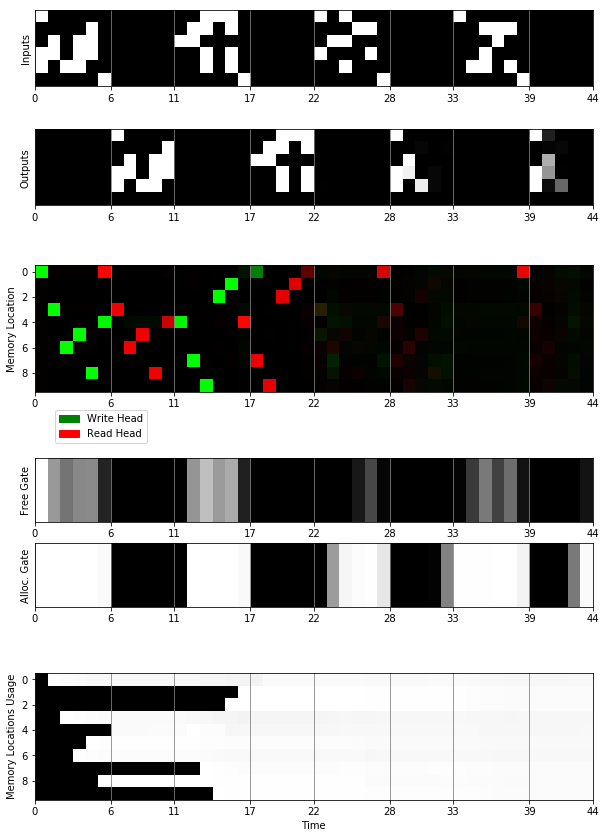

In [28]:
best_indx = np.argmin(losses)
print(losses[best_indx])
best_input, best_output, best_memview = inputs[best_indx], outputs[best_indx], views[best_indx]

visualize_op(best_input, best_output, best_memview)

## Trained on Length-4 Series

In [29]:
ckpts_dir = os.path.join(os.path.dirname("__file__"), 'checkpoints')

tf.reset_default_graph()
session = tf.InteractiveSession()

ncomputer = DNC(
    FeedforwardController,
    input_size=6,
    output_size=6,
    max_sequence_length=44,
    memory_words_num=10,
    memory_word_size=10,
    memory_read_heads=1,
    batch_size=1
)

ncomputer.restore(session, ckpts_dir, 'model-series-4')

INFO:tensorflow:Restoring parameters from checkpoints/model-series-4/model.ckpt


In [30]:
outputs, memory_views = ncomputer.get_outputs()
squashed_output = tf.sigmoid(outputs)
clipped_output = tf.clip_by_value(squashed_output, 1e-6, 1. - 1e-6)

loss = binary_cross_entropy(clipped_output, ncomputer.target_output)

### Accuracy on Length-4 Series

In [31]:
losses = []
matches = []
inputs = []
outputs = []
views = []

for i in range(1000):
    
    in_sequences = []
    out_sequences = []
    
    for k in range(4):
        input_data, target_output = generate_data(1, 5, 6)
        in_sequences.append(input_data)
        out_sequences.append(target_output)
    
    one_big_input = np.concatenate(in_sequences, axis=1)
    one_big_output = np.concatenate(out_sequences, axis=1)

    l, o, v = session.run([
        loss,
        squashed_output,
        memory_views
    ], feed_dict={
        ncomputer.input_data: one_big_input,
        ncomputer.target_output: one_big_output,
        ncomputer.sequence_length: 44
    })
    
    losses.append(l)
    inputs.append(one_big_input)
    outputs.append(o)
    views.append(v)
    matches.append(np.allclose(one_big_output, np.around(o)))

print("Avg. Accuracy: %.4f" % (np.mean(matches)))
print("Avg. Loss: %.4f" % (np.mean(losses)))

Avg. Accuracy: 1.0000
Avg. Loss: 0.0000


### Visualization on Length-4 Series

#### Best Run

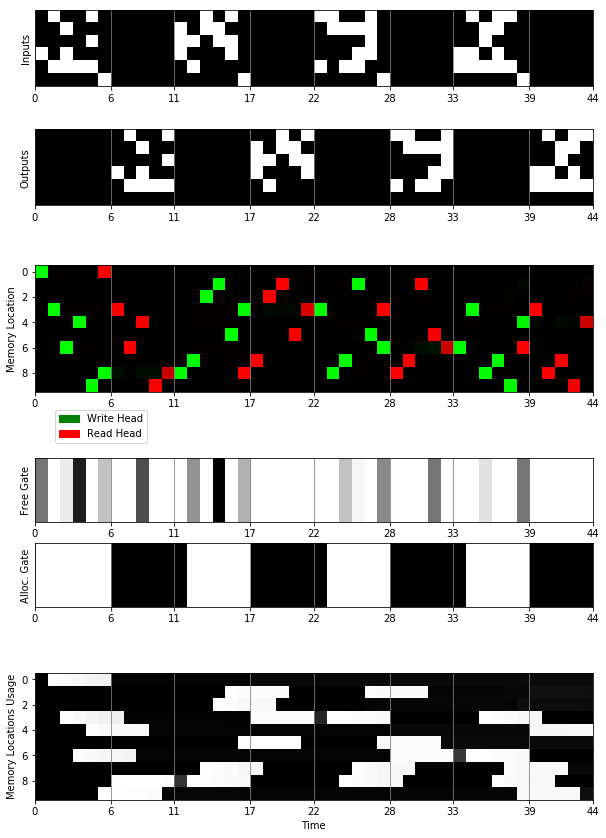

In [32]:
in_sequences = []
out_sequences = []
    
for k in range(4):
    input_data, target_output = generate_data(1, 5, 6)
    in_sequences.append(input_data)
    out_sequences.append(target_output)
    
one_big_input = np.concatenate(in_sequences, axis=1)
one_big_output = np.concatenate(out_sequences, axis=1)

l, o, v = session.run([
    loss,
    squashed_output,
    memory_views
], feed_dict={
    ncomputer.input_data: one_big_input,
    ncomputer.target_output: one_big_output,
    ncomputer.sequence_length: 44
})

visualize_op(one_big_input, o, v)

## Generalization and Memory Scalability

In [17]:
def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

In [18]:
ckpts_dir = os.path.join(os.path.dirname("__file__"), 'checkpoints')

word_counts = [10, 15, 20, 25, 30, 35, 40, 45]
sequnce_lengthes = [5, 10, 15, 20, 25, 30, 35, 40]

pairs = list(itertools.product(word_counts, sequnce_lengthes))
fraction_correct = np.zeros((8, 8))
count_done = 0

llprint("Finished 0/64")

for i, seq_size in enumerate(sequnce_lengthes):
    for j, mem_size in enumerate(word_counts):
        
        graph = tf.Graph()
        with graph.as_default():
            with tf.Session(graph=graph) as session:
                
                ncomputer = DNC(FeedforwardController, 6, 6, 2 * seq_size + 1, mem_size, 10, 1, 1)
                ncomputer.restore(session, ckpts_dir, 'model-single-10')
        
                output,_ = ncomputer.get_outputs()
                squashed_output = tf.sigmoid(output)
        
                matches = []
                for k in range(100):
                    input_data, target_output = generate_data(1, seq_size, 6)
                    dnc_output = session.run(squashed_output, feed_dict={
                        ncomputer.input_data: input_data,
                        ncomputer.sequence_length: 2 * seq_size + 1
                    })
            
                    matches.append(np.array_equal(np.around(dnc_output), target_output))
        
                fraction_correct[i, j] = np.mean(matches)
        
        count_done += 1
        llprint("\rFinished %d/64" % count_done)

Finished 0/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 1/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 2/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 3/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 4/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 5/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 6/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 7/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 8/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 9/64INFO:tensorflow:Restoring parameters from checkpoints/model-single-10/model.ckpt
Finished 10/64INFO:tensorflow:Restoring parameters from chec

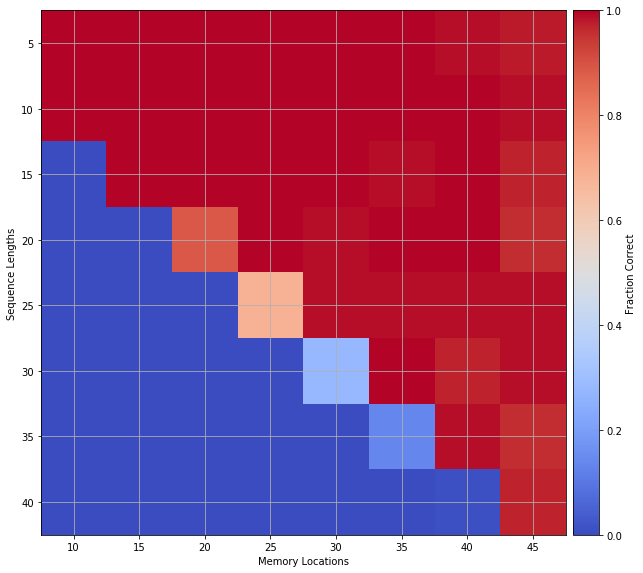

In [19]:
fig, ax = plt.subplots()

imax = ax.imshow(fraction_correct, cmap=plt.cm.coolwarm)

ax.set_ylabel('Sequence Lengths')
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_yticklabels(['5', '10', '15', '20', '25', '30', '35', '40'])

ax.set_xlabel('Memory Locations')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['10', '15', '20', '25', '30', '35', '40', '45'])

ax.grid(True)

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(imax, cax=cbar_ax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], label='Fraction Correct')